In [1]:
%load_ext autoreload
%autoreload 2
    
from leaguesync import * 
from leaguesync.pike13 import logger
import logging

logging.basicConfig()
logger.setLevel(logging.DEBUG)

import warnings

p13 = Pike13('./league-remote.env')

pdf = Pike13DataFrames(p13)

/Users/eric/proj/league-projects/leaguesync/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/eric/proj/league-projects/leaguesync/src/leaguesync/pike13.py:709: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  visits[c] = pd.to_datetime(visits[c], errors='ignore')
/Users/eric/proj/league-projects/leaguesync/src/leaguesync/pike13.py:709: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  visits[c] = pd.to_datetime(visits[c], errors='ignore')
/Users/eric/proj/league-projects/leaguesync/src/leaguesync/pike13.py:709: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  visits[c] = pd.to_datetime(visits[c], errors='ignore')
/Users/eric/proj/league-projects/leaguesync/src/leaguesync/pike13.py:709: FutureWarning: errors='ignore' is deprecated an

<Axes: xlabel='visit_month'>

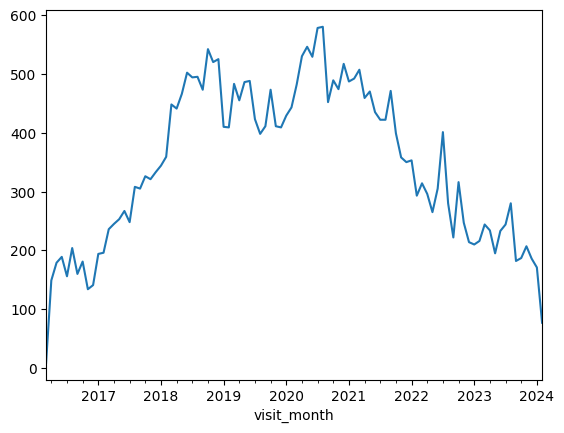

In [2]:

visits = pdf.visits
visits.groupby(visits.visit_month).event_occurrence_id.nunique().plot()


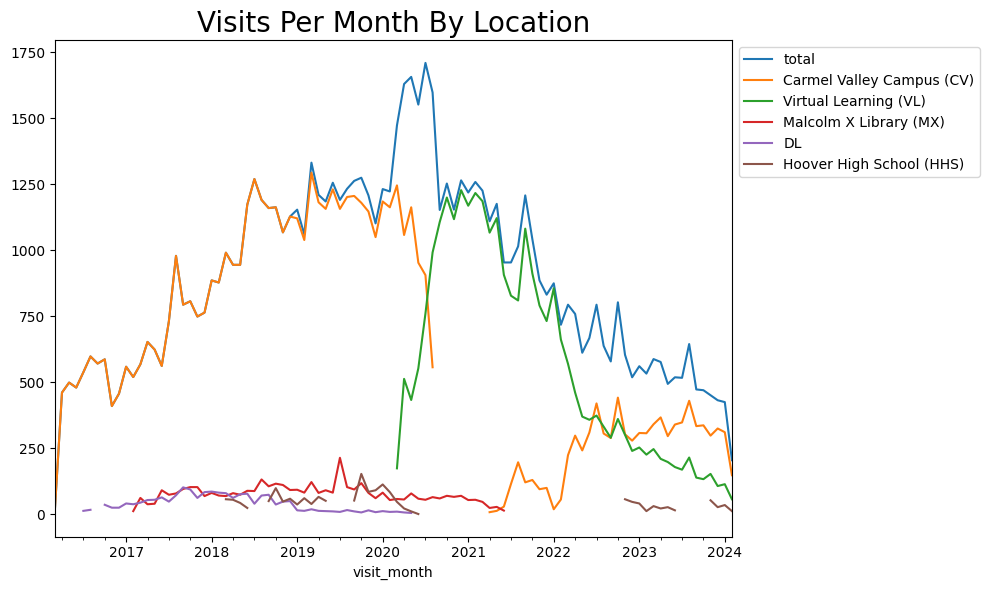

In [20]:
t = pdf.visits\
    .merge(pdf.event_occurrences[['event_occurrence_id','event_id','location_id']], on ='event_occurrence_id', how='left')\
    .merge(pdf.locations, on='location_id',how='left')\
    .merge(pdf.events[['event_id','event_name','service_id','service_type']], on ='event_id', how='left')

def get_name(v):
    names = ['total', 'SMH','WMS','SEM','DL','SMD','VL','LH','SM','Gompers']
    import re
    for e in  re.split('@|\s', v):
        if e in names:
            return e
    return None

t.loc[t.location_name.isnull(),'location_name'] = t[t.location_name.isnull()]['event_name'].apply(get_name)

import matplotlib.pyplot as plt

z = t.groupby(['visit_month', 'location_name']).visit_id.count().to_frame('n').unstack(-1)

z.columns = z.columns.droplevel(0)
z['total'] = z['Carmel Valley Campus (CV)'].fillna(0) + z['VL'].fillna(0) + z['Virtual Learning (VL)'].fillna(0)

top_loc = list(t.location_name.value_counts()[:5].index)


ax = z[['total']+top_loc].plot(figsize=(10,6))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Visits Per Month By Location', fontsize=20)

# Adjust layout to make room for the legend
plt.tight_layout()


In [18]:
top_loc

['Carmel Valley Campus (CV)',
 'Virtual Learning (VL)',
 'Malcolm X Library (MX)',
 'DL',
 'Hoover High School (HHS)']

In [4]:
pdf.services

,service_id,service_name,type,duration_in_minutes,maximum_clients,category_id,category_name,description,description_short,instructions
0,319359,Java Classes,GroupClass,90,8,93504.0,Group Classes,"<p><img alt="""" src=""https://d1nqv8xdwxria6.clo...","In-person and online instruction in Java, one ...",None
1,319636,Python Classes,GroupClass,90,8,93504.0,Group Classes,None,"Currently the worlds most popular language, Py...",None
2,320425,Intro to Programming,Course,60,6,93521.0,Camps,<p><br></p><p>Embark on an exciting journey in...,None,"<p>Welcome...before your first day of class, w..."
3,320135,Intro to Python,Course,60,10,93521.0,Camps,"<img alt="""" src=""https://d1nqv8xdwxria6.cloudf...",None,"<p>Welcome...before your first day of class, w..."
4,320134,Intro to Java,Course,60,10,93521.0,Camps,"<b><img alt="""" src=""https://d1nqv8xdwxria6.clo...",None,<b><p>Welcome...before your first day of class...
5,304450,AI Camp,Course,60,7,93521.0,Camps,"<p><img alt="""" src=""https://d1nqv8xdwxria6.clo...",None,"Location: 12625 High Bluff Dr #113, San Diego,..."
6,221389,SLAMS - 4 Day,Course,60,10,78358.0,Slams,<b>HOLIDAY SLAM is an opportunity for students...,,None
7,233439,SLAMS - 5 Day,Course,60,10,78358.0,Slams,<p><br></p><p>SLAMS (Short Learning Accelerate...,,
8,191144,CSA AP Prep,GroupClass,90,10,93519.0,Exam Preparation,AP Computer Science A Test Prep class - In thi...,None,None
9,256988,Private Lessons,GroupClass,90,1,93516.0,None,None,None,None


In [5]:
from datetime import datetime
import pandas as pd
import pytz 

one_month_ago = datetime.now(pytz.utc) - pd.DateOffset(weeks=2)

t = pdf.event_occurrences
t = t[t['start_at'] > one_month_ago]
t = t.merge(pdf.services[['service_id','service_name','category_name']])
t = t[['event_occurrence_id', 'event_id', 'service_id','location_id',  'event_name', 'service_name',  'start_at']]
t

,event_occurrence_id,event_id,service_id,location_id,event_name,service_name,start_at
0,218789468,12952206,181633,30565,Java@HHS,Java@HHS,2024-02-01 22:00:00+00:00
1,196062038,10722594,263387,22675,Java@CV Skipper,Java@CV,2024-02-01 23:30:00+00:00
2,224802956,13395526,269230,22675,Java 3:30-5pm New Students,Java Trial Class - IN PERSON,2024-02-01 23:30:00+00:00
3,196056385,6184136,183890,23281,Java@VL Zebra,Java@SMM,2024-02-02 01:00:00+00:00
4,196057356,8547623,263387,22675,Java@CV Deer,Java@CV,2024-02-02 01:00:00+00:00
...,...,...,...,...,...,...,...
1117,205459085,4950771,191042,22675,Java@CV Gnu,Java@VL,2024-05-30 01:30:00+00:00
1118,205459087,8819754,191042,23281,Java@VL Camel,Java@VL,2024-05-30 01:30:00+00:00
1119,224534115,13378382,319359,22675,"Java Beginner ( Levels 0, 1, 2)",Java Classes,2024-05-30 16:00:00+00:00
1120,218789490,12952206,181633,30565,Java@HHS,Java@HHS,2024-05-30 21:00:00+00:00


In [6]:
event_staff_rows = []
for eo in p13.event_occs:
    for staff in eo.get('staff_members',[]):
        event_staff_rows.append({
            'event_occurrence_id': eo['id'],
            'event_id' : eo['event_id'],
            'location_id': eo['location_id'],
            'event_name': eo['name'],
            'staff_id': staff['id'],
            'staff_name': staff['name']
        })

        

In [7]:
pd.DataFrame(event_staff_rows)

,event_occurrence_id,event_id,location_id,event_name,staff_id,staff_name
0,32053044,1411943,22675,[Level 1] @ CV Tiger,2274828,League Admin
1,32055163,1412158,22675,[Level 0] @ CV Penguin,2274828,League Admin
2,32052355,1406853,22675,[Level 2] @ CV Elephant,2274828,League Admin
3,32038901,1407021,22675,[Level 7] @ CV Caterpillar,2274828,League Admin
4,32433659,1433807,22675,[Level 8] @ CV Caterpillar,2274828,League Admin
...,...,...,...,...,...,...
66536,205459085,4950771,22675,Java@CV Gnu,5166821,Mike Johnson
66537,205459087,8819754,23281,Java@VL Camel,7442429,Colby Schexnayder
66538,224534115,13378382,22675,"Java Beginner ( Levels 0, 1, 2)",7101043,Accepting Students
66539,218789490,12952206,30565,Java@HHS,7861875,VA-Tammy Neuhaus


In [8]:
pdf = Pike13DataFrames(p13)
pdf.locations

,location_id,location_name,latitude,longitude,location_code
0,22675,Carmel Valley Campus (CV),32.9474,-117.239,CV
1,23281,Virtual Learning (VL),NaN,NaN,VL
2,30565,Hoover High School (HHS),32.7555,-117.098,HHS
3,27543,Malcolm X Library (MX),32.7108,-117.084,MX
4,37549,Innovation Middle School (IMS),32.8373,-117.174,IMS
5,38591,Millennial Tech Middle School (MT),32.7175,-117.089,MT
6,38688,NCRC Center,NaN,NaN,NaN
7,39104,GOLDEN HILL K-8,32.7188,-117.124,NaN
8,39105,MONTGOMERY MIDDLE,32.7885,-117.172,NaN
9,39106,TAFT MIDDLE,32.8017,-117.131,NaN


In [9]:
p13